#### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd "/content/drive/MyDrive/IASNLP"

# Importing Necessary Libraries

In [ ]:
!pip install sentencepiece
!pip install sacrebleu
!pip install tensorflow-gpu # ---> For GPU

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda, Layer, Embedding, LayerNormalization
import tensorflow_probability as tfp
import sentencepiece as spm
from sacrebleu.metrics import BLEU, CHRF, TER

import matplotlib.pyplot as plt

from collections import Counter

# Loading Data

We load the `train_data`, `train_dev_data`, `test_val_data` and `test_data` as well as the byte-pair encoder tokenizer for English and Bengali i.e. `sp_en_bpe` and `s_ben_bpe`.

In [ ]:
train_data, train_dev_data = pd.read_csv("train_data.csv")[['src', 'tgt']], pd.read_csv("train_dev.csv")[['src', 'tgt']] 
test_val_data, test_data = pd.read_csv("test_val.csv")[['src', 'tgt']], pd.read_csv("test_data.csv")[['src', 'tgt']]
sp_en_bpe, sp_ben_bpe = spm.SentencePieceProcessor(), spm.SentencePieceProcessor()
sp_en_bpe.load('eng_bpe.model'); sp_ben_bpe.load('ben_bpe.model');

# Data Preprocessing

We decide on some formats of the data and batches. We take the maximum tokens we can have per tokenized English and Bengali sentence to be `MAX_TOKENS = 60`. We use the vocabulary size of `32000`(i.e. `ENCODER_VOCAB = DECODER_VOCAB = 32000`). A batch size of `256` was choosen for our Mini-Batch Gradient Descent which is used to train our Model.

In [ ]:
MAX_TOKENS = 60
VOCAB_SIZE = 32000
BATCH_SIZE = 256
BUFFER_SIZE = BATCH_SIZE*4

The following two functions help in tokenizing an detokenizing the data based on our sentencepiece byte-pair encoding model.

In [ ]:
def tokenize(sentence, sp_model, add_bos = True, add_eos = True):
    bos = [sp_model.bos_id()] if add_bos else []
    eos = [sp_model.eos_id()] if add_eos else []
    inputs = bos + sp_model.encode_as_ids(sentence) + eos
    return np.reshape(np.array(inputs), [1, -1])
def detokenize(tokenized, sp_model, is_bos = True, is_eos = True):
    integers = np.squeeze(tokenized).tolist()
    if is_eos:
        return sp_model.DecodeIdsWithCheck(integers[int(is_bos):integers.index(sp_model.eos_id())])
    else:
        if sp_model.pad_id() in tokenized:
            return sp_model.DecodeIdsWithCheck(integers[int(is_bos):integers.index(sp_model.pad_id())])
        else:
            return sp_model.DecodeIdsWithCheck(integers[int(is_bos):])

We have tokenized the data.

In [ ]:
# Tokenization
src_train_data_enc = [np.squeeze(tokenize(train_data['src'].iloc[i], sp_en_bpe)) for i in range(train_data.shape[0])]
tgt_train_data_enc = [np.squeeze(tokenize(train_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(train_data.shape[0])]
src_train_dev_data_enc = [np.squeeze(tokenize(train_dev_data['src'].iloc[i], sp_en_bpe)) for i in range(train_dev_data.shape[0])]
tgt_train_dev_data_enc = [np.squeeze(tokenize(train_dev_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(train_dev_data.shape[0])]
src_test_val_data_enc = [np.squeeze(tokenize(test_val_data['src'].iloc[i], sp_en_bpe)) for i in range(test_val_data.shape[0])]
tgt_test_val_data_enc = [np.squeeze(tokenize(test_val_data['tgt'].iloc[i], sp_ben_bpe)) for i in range(test_val_data.shape[0])]

We have padded the data with post-truncation and post padding upto MAX_TOKENS number of tokens.

In [ ]:
# Padding
# The reason why we add MAX_TOKENS+1 after-pad length for Bengali is that when we form the tf.Dataset later, we will shift the target sentence once and will truncate the last token once
# Hence, it will get adjusted
train_src = tf.keras.preprocessing.sequence.pad_sequences(src_train_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_dev_src = tf.keras.preprocessing.sequence.pad_sequences(src_train_dev_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
train_dev_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_train_dev_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
test_val_src = tf.keras.preprocessing.sequence.pad_sequences(src_test_val_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')
test_val_tgt = tf.keras.preprocessing.sequence.pad_sequences(tgt_test_val_data_enc, maxlen = MAX_TOKENS, padding='post', truncating='post')

Below, we discard all those pairs where the tokenized source or target sentences are larger than MAX_TOKENS number of tokens.

In [ ]:
# Removing all pairs whose either the target sentence or source setence exceeds MAX_TOKENS number of tokens
same_idx = list(set([i for i in range(train_src.shape[0]) if train_src[i][-1] == 1 or train_src[i][-1] == 0]).intersection(set([i for i in range(train_tgt.shape[0]) if train_tgt[i][-1] == 1 or train_tgt[i][-1] == 0])))
train_src = train_src[same_idx]
train_tgt = train_tgt[same_idx]
same_idx = list(set([i for i in range(train_dev_src.shape[0]) if train_dev_src[i][-1] == 1 or train_dev_src[i][-1] == 0]).intersection(set([i for i in range(train_dev_tgt.shape[0]) if train_dev_tgt[i][-1] == 1 or train_dev_tgt[i][-1] == 0])))
train_dev_src = train_dev_src[same_idx]
train_dev_tgt = train_dev_tgt[same_idx]
same_idx = list(set([i for i in range(test_val_src.shape[0]) if test_val_src[i][-1] == 1 or test_val_src[i][-1] == 0]).intersection(set([i for i in range(test_val_tgt.shape[0]) if test_val_tgt[i][-1] == 1 or test_val_tgt[i][-1] == 0])))
test_val_src = test_val_src[same_idx]
test_val_tgt = test_val_tgt[same_idx]

In [ ]:
train_labels = np.zeros(train_tgt.shape)
train_labels[:,0:train_tgt.shape[1] -1] = train_tgt[:,1:]
train_dev_labels = np.zeros(train_dev_tgt.shape)
train_dev_labels[:,0:train_dev_tgt.shape[1] -1] = train_dev_tgt[:,1:]
test_val_labels = np.zeros(test_val_tgt.shape)
test_val_labels[:,0:test_val_tgt.shape[1] -1] = test_val_tgt[:,1:]

In [ ]:
print("*** Preprocessed Data ***")
print("Train Data Shape(Source): ", train_src.shape)
print("Train Data Shape(Target): ", train_tgt.shape)
print("Train Labels Shape(Target): ", train_labels.shape)
print("Train Dev Data Shape(Source): ", train_dev_src.shape)
print("Train Dev Data Shape(Target): ", train_dev_tgt.shape)
print("Train Dev Labels Shape(Target): ", train_dev_labels.shape)
print("Test Val Data Shape(Source): ", test_val_src.shape)
print("Test Val Data Shape(Target): ", test_val_tgt.shape)
print("Test Labels Shape(Target): ", test_val_labels.shape)

*** Preprocessed Data ***
Train Data Shape(Source):  (154836, 60)
Train Data Shape(Target):  (154836, 60)
Train Labels Shape(Target):  (154836, 60)
Train Dev Data Shape(Source):  (3649, 60)
Train Dev Data Shape(Target):  (3649, 60)
Train Dev Labels Shape(Target):  (3649, 60)
Test Val Data Shape(Source):  (1194, 60)
Test Val Data Shape(Target):  (1194, 60)
Test Labels Shape(Target):  (1194, 60)


Below we prepare the data in the form ready to feed to the Model.

In [ ]:
train_data_prep = tf.data.Dataset.from_tensor_slices((train_src, train_tgt, train_labels))
train_dev_data_prep = tf.data.Dataset.from_tensor_slices((train_dev_src, train_dev_tgt, train_dev_labels))
test_val_data_prep = tf.data.Dataset.from_tensor_slices((test_val_src, test_val_tgt, test_val_labels))

Below, we can see how our data looks

In [ ]:
for encoder_inputs, decoder_inputs, labels in train_data_prep.take(1):
    print(f'encoder_inputs.shape: {encoder_inputs.shape}')
    print(f'decoder_inputs.shape: {decoder_inputs.shape}')
    print(f"labels.shape: {labels.shape}")

encoder_inputs.shape: (60,)
decoder_inputs.shape: (60,)
labels.shape: (60,)


# Model

We will use the Transformer Architechture with the following hyperparameters.

In [ ]:
# Transformer parameters
d_model = 256 # 512 in the original paper
d_k = 32 # 64 in the original paper
d_v = 32 # 64 in the original paper
n_heads = 4 # 8 in the original paper
n_encoder_layers = 2 # 6 in the original paper
n_decoder_layers = 2 # 6 in the original paper

max_token_length = MAX_TOKENS # 512 in the original paper

In [ ]:
class SingleHeadAttention(Layer):
  def __init__(self, input_shape=(3, -1, d_model), dropout=.0, masked=None):
    super(SingleHeadAttention, self).__init__()
    self.q = Dense(d_k, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.normalize_q = Lambda(lambda x: x / np.sqrt(d_k))
    self.k = Dense(d_k, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.v = Dense(d_v, input_shape=(-1, d_model), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    self.dropout = dropout
    self.masked = masked
  
  # Inputs: [query, key, value]
  def call(self, inputs, training=None):
    assert len(inputs) == 3
    # We use a lambda layer to divide vector q by sqrt(d_k) according to the equation
    q = self.normalize_q(self.q(inputs[0]))
    k = self.k(inputs[1])
    # The dimensionality of q is (batch_size, query_length, d_k) and that of k is (batch_size, key_length, d_k)
    # So we will do a matrix multication by batch after transposing last 2 dimensions of k
    # tf.shape(attn_weights) = (batch_size, query_length, key_length)
    attn_weights = tf.matmul(q, tf.transpose(k, perm=[0,2,1]))
    if self.masked: # Prevent future attentions in decoding self-attention
      # Create a matrix where the strict upper triangle (not including main diagonal) is filled with -inf and 0 elsewhere
      length = tf.shape(attn_weights)[-1]
      #attn_mask = np.triu(tf.fill((length, length), -np.inf), k=1) # We need to use tensorflow functions instead of numpy
      attn_mask = tf.fill((length, length), -np.inf)
      attn_mask = tf.linalg.band_part(attn_mask, 0, -1) # Get upper triangle
      attn_mask = tf.linalg.set_diag(attn_mask, tf.zeros((length))) # Set diagonal to zeros to avoid operations with infinity
      # This matrix is added to the attention weights so all future attention will have -inf logits (0 after softmax)
      attn_weights += attn_mask
    # Softmax along the last dimension
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    if training: # Attention dropout included in the original paper. This is possibly to encourage multihead diversity.
      attn_weights = tf.nn.dropout(attn_weights, rate=self.dropout)
    v = self.v(inputs[2])
    return tf.matmul(attn_weights, v)

class MultiHeadAttention_my(Layer):
  def __init__(self, dropout=.0, masked=None):
    super(MultiHeadAttention_my, self).__init__()
    self.attn_heads = list()
    for i in range(n_heads): 
      self.attn_heads.append(SingleHeadAttention(dropout=dropout, masked=masked))
    self.linear = Dense(d_model, input_shape=(-1, n_heads * d_v), kernel_initializer='glorot_uniform', 
                   bias_initializer='glorot_uniform')
    
  def call(self, x, training=None):
    attentions = [self.attn_heads[i](x, training=training) for i in range(n_heads)]
    concatenated_attentions = tf.concat(attentions, axis=-1)
    return self.linear(concatenated_attentions)

class TransformerEncoder(Layer):
  def __init__(self, dropout=.1, attention_dropout=.0, **kwargs):
    super(TransformerEncoder, self).__init__(**kwargs)
    self.dropout_rate = dropout
    self.attention_dropout_rate = attention_dropout
  def build(self, input_shape):
    self.multihead_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization1 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.linear1 = Dense(input_shape[-1] * 4, input_shape=input_shape, activation='relu',
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.linear2 = Dense(input_shape[-1], input_shape=self.linear1.compute_output_shape(input_shape),
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization2 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    super(TransformerEncoder, self).build(input_shape)
  def call(self, x, training=None):
    sublayer1 = self.multihead_attention((x, x, x), training=training)
    sublayer1 = self.dropout1(sublayer1, training=training)
    layernorm1 = self.layer_normalization1(x + sublayer1)
    
    sublayer2 = self.linear2(self.linear1(layernorm1))
    sublayer1 = self.dropout2(sublayer2, training=training)
    layernorm2 = self.layer_normalization2(layernorm1 + sublayer2)
    return layernorm2
  def compute_output_shape(self, input_shape):
    return input_shape

class TransformerDecoder(Layer):
  def __init__(self, dropout=.0, attention_dropout=.0, **kwargs):
    super(TransformerDecoder, self).__init__(**kwargs)
    self.dropout_rate = dropout
    self.attention_dropout_rate = attention_dropout
  def build(self, input_shape):
    self.multihead_self_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate, masked=True)
    self.dropout1 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization1 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.multihead_encoder_attention = MultiHeadAttention_my(dropout=self.attention_dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization2 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    
    self.linear1 = Dense(input_shape[-1] * 4, input_shape=input_shape, activation='relu',
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.linear2 = Dense(input_shape[-1], input_shape=self.linear1.compute_output_shape(input_shape),
                        kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.dropout3 = tf.keras.layers.Dropout(self.dropout_rate)
    self.layer_normalization3 = LayerNormalization(input_shape=input_shape, epsilon=1e-6)
    super(TransformerDecoder, self).build(input_shape)
  def call(self, x, hidden, training=None):
    sublayer1 = self.multihead_self_attention((x, x, x))
    sublayer1 = self.dropout1(sublayer1, training=training)
    layernorm1 = self.layer_normalization1(x + sublayer1)
    
    sublayer2 = self.multihead_encoder_attention((x, hidden, hidden))
    sublayer2 = self.dropout2(sublayer2, training=training)
    layernorm2 = self.layer_normalization2(layernorm1 + sublayer2)
    
    sublayer3 = self.linear2(self.linear1(layernorm1))
    sublayer3 = self.dropout3(sublayer3, training=training)
    layernorm3 = self.layer_normalization2(layernorm2 + sublayer3)
    return layernorm3
  def compute_output_shape(self, input_shape):
    return input_shape

class SinusoidalPositionalEncoding(Layer): # This is a TensorFlow implementation of https://github.com/graykode/nlp-tutorial/blob/master/5-1.Transformer/Transformer_Torch.ipynb
  def __init__(self):
    super(SinusoidalPositionalEncoding, self).__init__()
    self.sinusoidal_encoding = np.array([self.get_positional_angle(pos) for pos in range(max_token_length)], dtype=np.float32)
    self.sinusoidal_encoding[:, 0::2] = np.sin(self.sinusoidal_encoding[:, 0::2])
    self.sinusoidal_encoding[:, 1::2] = np.cos(self.sinusoidal_encoding[:, 1::2])
    self.sinusoidal_encoding = tf.cast(self.sinusoidal_encoding, dtype=tf.float32) # Casting the array to Tensor for slicing
  def call(self, x):
    return x + self.sinusoidal_encoding[:tf.shape(x)[1]]
  def compute_output_shape(self, input_shape):
    return input_shape
  def get_angle(self, pos, dim):
    return pos / np.power(10000, 2 * (dim // 2) / d_model)
  def get_positional_angle(self, pos):
    return [self.get_angle(pos, dim) for dim in range(d_model)]

class Transformer(Model):
  def __init__(self, dropout=.1, attention_dropout=.0, **kwargs):
    super(Transformer, self).__init__(**kwargs)
    self.encoding_embedding = Embedding(VOCAB_SIZE, d_model)
    self.decoding_embedding = Embedding(VOCAB_SIZE, d_model)
    self.pos_encoding = SinusoidalPositionalEncoding()
    self.encoder = [TransformerEncoder(dropout=dropout, attention_dropout=attention_dropout) for i in range(n_encoder_layers)]
    self.decoder = [TransformerDecoder(dropout=dropout, attention_dropout=attention_dropout) for i in range(n_decoder_layers)]
    self.decoder_final = Dense(VOCAB_SIZE, input_shape=(None, d_model))
  def call(self, inputs, training=None): # Source_sentence and decoder_input
    source_sentence, decoder_input = inputs
    embedded_source = self.encoding_embedding(source_sentence)
    encoder_output = self.pos_encoding(embedded_source)
    for encoder_unit in self.encoder:
      encoder_output = encoder_unit(encoder_output, training=training)
    
    embedded_target = self.decoding_embedding(decoder_input)
    decoder_output = self.pos_encoding(embedded_target)
    for decoder_unit in self.decoder:
      decoder_output = decoder_unit(decoder_output, encoder_output, training=training)
    if training:
      decoder_output = self.decoder_final(decoder_output)
      decoder_output = tf.nn.softmax(decoder_output, axis=-1)
    else:
      decoder_output = self.decoder_final(decoder_output[:, -1:, :])
      decoder_output = tf.nn.softmax(decoder_output, axis=-1)
    return decoder_output

In [ ]:
transformer = Transformer(dropout=0.3) # Instantiating a new transformer model
train = [tf.cast(train_src, dtype=tf.float32), tf.cast(train_tgt, dtype=tf.float32)] # Cast the tuples to tensors
validation = [tf.cast(train_dev_src, dtype=tf.float32), tf.cast(train_dev_tgt, dtype=tf.float32)]

In [ ]:
transformer.build([train_src.shape, train_tgt.shape])
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  8192000   
                                                                 
 embedding_1 (Embedding)     multiple                  8192000   
                                                                 
 sinusoidal_positional_encod  multiple                 0         
 ing (SinusoidalPositionalEn                                     
 coding)                                                         
                                                                 
 transformer_encoder (Transf  multiple                 658304    
 ormerEncoder)                                                   
                                                                 
 transformer_encoder_1 (Tran  multiple                 658304    
 sformerEncoder)                                       

## Training

In [ ]:
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 10
checkpoint_filepath = '/Models/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [ ]:
with tf.device('/device:GPU:0'):
    history = transformer.fit(train, tf.cast(train_labels, dtype=tf.float32), batch_size=256, epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/10
605/605 [==============================] - 368s 583ms/step - loss: 1.8724 - accuracy: 0.7966
Epoch 2/10
605/605 [==============================] - 370s 611ms/step - loss: 1.5746 - accuracy: 0.8042
Epoch 3/10
605/605 [==============================] - 370s 611ms/step - loss: 1.4610 - accuracy: 0.8108
Epoch 4/10
605/605 [==============================] - 370s 611ms/step - loss: 1.3757 - accuracy: 0.8151
Epoch 5/10
605/605 [==============================] - 370s 612ms/step - loss: 1.2967 - accuracy: 0.8191
Epoch 6/10
605/605 [==============================] - 370s 612ms/step - loss: 1.2259 - accuracy: 0.8226
Epoch 7/10
605/605 [==============================] - 370s 612ms/step - loss: 1.1670 - accuracy: 0.8258
Epoch 8/10
605/605 [==============================] - 372s 614ms/step - loss: 1.1166 - accuracy: 0.8288
Epoch 9/10
605/605 [==============================] - 371s 614ms/step - loss: 1.0731 - accuracy: 0.8314
Epoch 10/10
605/605 [==============================] - 371s 614m

In [ ]:
transformer.save_weights("model_weights")

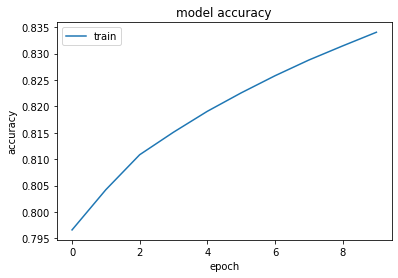

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.figure(figsize=(10,10))
plt.show()

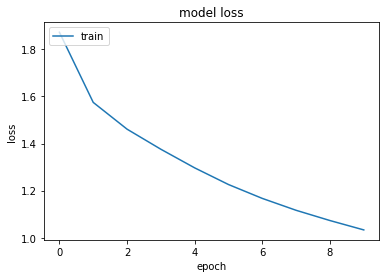

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.figure(figsize=(10,10))
plt.show()

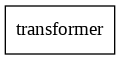

In [ ]:
dot_img_file = "d_mod-"+str(d_model)+"-d_k-"+str(d_k)+"-d_v-"+str(d_v)+"-n_heads-"+str(n_heads)+"-enc_lays-"+str(n_encoder_layers)+"-dec_lays-"+str(n_decoder_layers)+'-transformer.png'
tf.keras.utils.plot_model(transformer, to_file=dot_img_file, show_shapes=True)

In [ ]:
# transformer = keras.models.load_model('./Model-2/')

## Testing

We use greedy selection.

In [ ]:
def greedy_translate(model, source_sentence, target_sentence_start=sp_ben_bpe.bos_id()):
  # Tokenizing and padding
  source_seq = tokenize(source_sentence, sp_en_bpe)
  source_seq = tf.keras.preprocessing.sequence.pad_sequences(source_seq, maxlen = MAX_TOKENS, padding='post', truncating='post')
  predict_seq = [[target_sentence_start]]
  
  predict_sentence = [target_sentence_start] # Deep copy here to prevent updates on target_sentence_start
  while predict_sentence[-1] != sp_ben_bpe.eos_id() and len(predict_sentence) < MAX_TOKENS:
    predict_output = model([np.array(source_seq), np.array(predict_seq)], training=None)
    predict_label = tf.argmax(predict_output, axis=-1) # Pick the label with highest softmax score
    predict_seq = tf.concat([predict_seq, predict_label], axis=-1) # Updating the prediction sequence
    predict_sentence.append(predict_label[0][0].numpy())
  
  if len(predict_sentence) == MAX_TOKENS:
      return detokenize(predict_sentence, sp_ben_bpe, True, False)
  return detokenize(predict_sentence, sp_ben_bpe)

Playing aroung with the model to see where it makes mistake, as of now, because of low training data, I feel the model is not well exposed to various terms and words.

In [ ]:
sentence = "I love you."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I love you.
Bengali Sentence:  আমি তোমাকে ভালবাসি।


In [ ]:
sentence = "Hello!"
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  Hello!
Bengali Sentence:  হ্যালো!


In [ ]:
sentence = "Let's start!"
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  Let's start!
Bengali Sentence:  আসুন শুরু যাক!


In [ ]:
sentence = "Life is like a walking shadow."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  Life is like a walking shadow.
Bengali Sentence:  জীবন খুবই খারাপ।


In [ ]:
sentence = "I need more data!"
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I need more data!
Bengali Sentence:  আমি কি আরও বেশি তথ্য পেয়েছি!


In [ ]:
sentence = "I need more data,"
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I need more data,
Bengali Sentence:  আমি আরও বিস্তারিত বিস্তারিত বিস্তারিত বিস্তারিত বলব


In [ ]:
sentence = "I need more data."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", greedy_translate(transformer, sentence))

English Sentence:  I need more data.
Bengali Sentence:  আমি আরও বিস্তারিত তথ্য পেয়েছি।


### Machine Translation Evaluation Metric

Being a small model for obvious computational resource constraint. We see that the MT Evaluation metrics are quite poor.

In [ ]:
sentences = list(test_val_data['src'][:250])
refs = [list(test_val_data['tgt'][:250])]
sys = [greedy_translate(transformer, sentence) for sentence in sentences]

In [ ]:
bleu = BLEU()
bleu.corpus_score(sys, refs)

BLEU = 0.64 12.9/1.8/0.4/0.0 (BP = 0.967 ratio = 0.968 hyp_len = 3468 ref_len = 3583)

In [ ]:
chrf = CHRF()
chrf.corpus_score(sys, refs)

chrF2 = 19.99

In [ ]:
ter = TER()
ter.corpus_score(sys, refs)

TER = 104.46

We look at the model's output for unseen test data which is prepared from `Indic-WAT`.

In [ ]:
val_perf = pd.DataFrame({"src":sentences, "sys":sys, "refs":refs[0]})
val_perf

,src,sys,refs
0,"Through her work, she spread the message of th...","তিনি বলেন, ‘এই ধরনের উদ্যোগ ও পরিবেশ ও অক্ষমতা...",নিজের কর্মেরউদাহরণ স্থাপন করে তিনি মানুষকে সেব...
1,Interacting with beneficiaries and store owner...,কেন্দ্রীয় মন্ত্রী শ্রী নরেন্দ্র মোদী ও নিকোবর...,সারা দেশের ৫ হাজারেরও বেশি স্থান থেকে দোকান মা...
2,These include:,এই ধরনের বৈশিষ্ট্য নিম্নরূপ:,এই প্রকল্পগুলির মধ্যে রয়েছে-
3,It is no surprise that today Japan is India’s ...,এটি বিশ্বের বৃহত্তম বিশ্বের বৃহত্তম অর্থনীতির ...,জাপান যে বর্তমানে ভারতের চতুর্থ বৃহত্তম প্রত্য...
4,Record growth in last two and a half years,গত বছর ধরে দুই পক্ষের মধ্যে শীর্ষে শীর্ষে শীর্...,গত আড়াই বছরেরেকর্ড পরিমাণ অগ্রগতি
...,...,...,...
245,•India will emerge as a global leader in trans...,@আরএম-এর দশকের মধ্যে ভারত-প্রশান্ত মহাসাগরীয় ...,· সর্বাধুনিক প্রযুক্তি এবং দক্ষ শ্রমিকের ব্যবহ...
246,BHIM stands for Bharat Interface for Money.,ভারত-বাংলাদেশ কার্ড নিয়ে এসেছে।,BHIM মানে ভারত ইন্টারফেস ফর মানি।
247,"Heartiest congratulations, Beti Shivangi.","হৃদয়-দাওয়া, হেমন্ত-পাউন্ড।",কন্যা শিবাঙ্গীকে অনেক অনেক অভিনন্দন!
248,"But, we are now awaiting the rains.","কিন্তু, আমরা বৃষ্টি পর্যন্ত আছি।",বর্ষার প্রতীক্ষা চলছেই ।


In [ ]:
val_perf.to_csv("val_data_perf.csv")

We below see how the model predicts on the held out data from the same dataset. The model performs slightly better.

In [ ]:
sentences = list(train_dev_data['src'][:250])
refs = [list(train_dev_data['tgt'][:250])]
sys = [greedy_translate(transformer, sentence) for sentence in sentences]

In [ ]:
bleu = BLEU()
bleu.corpus_score(sys, refs)

BLEU = 0.80 15.2/2.5/0.4/0.0 (BP = 1.000 ratio = 1.064 hyp_len = 2561 ref_len = 2406)

In [ ]:
chrf = CHRF()
chrf.corpus_score(sys, refs)

chrF2 = 20.25

In [ ]:
ter = TER()
ter.corpus_score(sys, refs)

TER = 107.92

In [ ]:
train_dev_perf = pd.DataFrame({"src":sentences, "sys":sys, "refs":refs[0]})
train_dev_perf

,src,sys,refs
0,We beg our Protestant and Jewish friends to pu...,"আমরা যখন আমাদের খ্রিস্টানদেরকে সমর্থন করি, তখন...",কোন কোন ক্ষেত্রে কর্তৃপক্ষ এবং ধর্মীয় নেতারা ...
1,"Sa'd advised Muhammad: ""Don't be hard on him. ...","ড.পূ.পূ.পূ: ""আমরা তোমাদের কাছে তাঁর কাছে কথা ব...","সা'দ মুহাম্মাদকে বলেন: ""তার প্রতি কঠোর হবেন না..."
2,Photo by 'Save Gaza Project',"ছবি ফ্লিকার ব্যবহারকারী বলেন, ‘আমি ‘আমি এই প্র...","ছবি ""সেভ গাজা প্রজেক্টের""।'"
3,"So, therefore, we need to test batteries under...","সুতরাং, আমাদের লক্ষ্য ছিল যে, আমাদের জন্য আমাদ...","অতএব, আমআদের কিছুটা মান অবস্থাগুলির অধীনে ব্যা..."
4,This party is also contesting in the elections.,এই নির্বাচনে রাজনৈতিক দলের নির্বাচন চলছে।,নির্বাচনে এই দলের মধ্যেই প্রতিদ্বন্দ্বিতা হবে।
...,...,...,...
245,All of them went in favour of Congress.,কংগ্রেস থেকে তাঁদের মধ্যে ক্ষোভ প্রকাশ করে।,এ সবই কংগ্রেসের পক্ষে গিয়েছে।
246,"But even if India is not as safe as Europe, it...","কিন্তু ভারত যদি বাংলাদেশের বাইরে থাকে, তাহলে ব...","ভারত ইউরোপের মত নিরাপদ নয় ঠিকই, তবে বাংলাদেশের..."
247,What does a human have?,মানুষের কি কি?,কোনও পুরুষেরই কি আছে?
248,Have you seen it lately?,আপনি কি দেখেছেন?,ইতি পূর্বে দেখা হয়েছে কি?


In [ ]:
val_perf.to_csv("train_dev_data_perf.csv")

We below sample the words using the Transformer predictions for probability values. But here the difference is we "sample" the value and not just choose the max value. This gives us interesting variations of a sentence's translation. It is based on the idea of minimizing Bayes's Risk.

In [ ]:
def sampling_translate(model, source_sentence, temperature=0.6, target_sentence_start=sp_ben_bpe.bos_id()):
  # Tokenizing and padding
  source_seq = tokenize(source_sentence, sp_en_bpe)
  source_seq = tf.keras.preprocessing.sequence.pad_sequences(source_seq, maxlen = MAX_TOKENS, padding='post', truncating='post')
  predict_seq = [[target_sentence_start]]
  logprob = 0
  
  predict_sentence = [target_sentence_start] # Deep copy here to prevent updates on target_sentence_start
  while predict_sentence[-1] != sp_ben_bpe.eos_id() and len(predict_sentence) < MAX_TOKENS:
    predict_output = model([np.array(source_seq), np.array(predict_seq)], training=None)
    probs = predict_output[-1].numpy()[0]
    log_probs = np.log(probs)
    u = np.random.uniform(low=1e-6, high=1.0 - 1e-6, size=log_probs.shape)
    g = -np.log(-np.log(u))
    sample_idx = np.argmax(log_probs + g * temperature, axis=-1)
    sample_prob = predict_output[-1].numpy()[0][sample_idx]
    logprob += np.log(sample_prob)
    predict_label = np.arange(predict_output.shape[-1])[sample_idx] # Sample the label softmax score
    predict_seq = tf.concat([predict_seq, tf.cast([[predict_label]], dtype=tf.int32)], axis=-1) # Updating the prediction sequence
    predict_sentence.append(predict_label)
  
  if len(predict_sentence) == MAX_TOKENS:
      return detokenize(predict_sentence, sp_ben_bpe, True, False), logprob
  return detokenize(predict_sentence, sp_ben_bpe), logprob

In [ ]:
sentence = "I love you."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", sampling_translate(transformer, sentence))

English Sentence:  I love you.
Bengali Sentence:  ('আমি ভালো ভালোবাসি।', -5.938353013189044)


In [ ]:
sentence = "Hi."
print("English Sentence: ", sentence)
print("Bengali Sentence: ", sampling_translate(transformer, sentence))

English Sentence:  Hi.
Bengali Sentence:  ('এক্কেবারে,', -11.502934694290161)


We below generaete multiple outcomes of a sentence's translation with a ROUGHE SIMILARITY score. It shows interesting results of which sentences the model thinks are closer to each other and to the translation.

In [ ]:
def generate_samples(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = [], []
    for _ in range(n_samples):
        sample, logp = sampling_translate(model, sentence, temperature)
        samples.append(sample)
        log_probs.append(logp)
    return samples, log_probs

In [ ]:
def rouge1_similarity(system, reference):
    sys_counter = Counter(system)
    ref_counter = Counter(reference)
    overlap = 0
    for token in sys_counter:
        token_count_sys = sys_counter[token]
        token_count_ref = ref_counter[token]
        overlap += min(token_count_ref, token_count_sys)
    precision = overlap / sum(sys_counter.values())
    recall = overlap / sum(ref_counter.values())
    if precision + recall != 0:
        rouge1_score = 2 * ((precision * recall)/(precision + recall))
    else:
        rouge1_score = 0     
    return rouge1_score

In [ ]:
def weighted_avg_overlap(samples, log_probs):
    scores = {}
    for index_candidate, candidate in enumerate(samples):    
        overlap, weight_sum = 0.0, 0.0
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):           
            if index_candidate == index_sample:
                continue
            sample_p = float(np.exp(logp))
            weight_sum += sample_p
            sample_overlap = rouge1_similarity(candidate, sample)
            overlap += sample_p * sample_overlap
        score = overlap / weight_sum
        scores[index_candidate] = score
    return scores

In [ ]:
def mbr_decode(sentence, n_samples, model=None, temperature=0.6):
    samples, log_probs = generate_samples(sentence, n_samples, model, temperature)
    scores = weighted_avg_overlap(samples, log_probs)
    max_score_key = max(scores, key=scores.get)
    return Counter({sample:score for sample, score in zip(samples, scores.values())})

Playing around with the model a bit.

In [ ]:
sentence = "I love you."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  I love you.
Bengali:  Counter({'আমি তোমাকে ভালবাসি।': 0.9714389708969126, 'আমি তোমাকে ভালোবাসি।': 0.9566426896653991, 'তোমাকে ভালোবাসি।': 0.8540486552294865, 'আমি ভালবাসি।': 0.7617118809931761, 'আমি তোমার ভালবাসা উপভোগ করি।': 0.7612547697912802, 'তুমি ভালো করেছো.': 0.6337957026536614, 'আমি তো খুশি।': 0.5696605045023561, 'আমি আপনার বন্ধু।': 0.45223510334778483})


In [ ]:
sentence = "Modiji is India's Prime Minister."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  Modiji is India's Prime Minister.
Bengali:  Counter({'কিন্তু নরেন্দ্র মোদী সরকারের।': 0.8481085839527179, 'কিন্তু নরেন্দ্র মোদী সরকার।': 0.8195907344954799, 'কিন্তু নরেন্দ্র মোদীর বায়োপ্রি।': 0.7855588704289592, 'নরেন্দ্র মোদি সরকারের।': 0.7792983727877886, 'নরেন্দ্র মোদী সরকারের ভারত।': 0.7783406115892316, 'নরেন্দ্র মোদী নরেন্দ্র মোদি।': 0.7538688664938117, 'মোদীর কথা নরেন্দ্র মোদী।': 0.7447190169731827, 'কিন্তু নরেন্দ্র মোদীর এই বৈঠকে নরেন্দ্র মোদী।': 0.7115931266867341, 'কিন্তু নরেন্দ্র মোদীর প্রধানমন্ত্রী নরেন্দ্র মোদীর।': 0.6610375561473062, 'নরেন্দ্র মোদী বলেন, ‘\u200c\u200c\u200c': 0.6327239463255885})


In [ ]:
sentence = "Thank You!"
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  Thank You!
Bengali:  Counter({'ধন্যবাদ!': 0.994706436015923, 'ধন্যবাদ তোমার!': 0.7265599904143797, 'ধন্যবাদ ধন্যবাদ!': 0.6666666666666669})


In [ ]:
sentence = "India is a shy country with second largest population."
translated_sentence = mbr_decode(sentence, 10, transformer)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  India is a shy country with second largest population.
Bengali:  Counter({'বিশ্বে বিশ্বের অনেক সংখ্যক দেশের জনসংখ্যা রয়েছে।': 0.7946034939254609, 'বিশ্বের জনসংখ্যার মধ্যে সবচেয়ে বেশি সংখ্যক দেশ।': 0.7707803780121407, 'বিশ্বে বিশ্বের সবচেয়ে বেশি সংখ্যক দেশ জুড়ে।': 0.7632283651059119, 'বিশ্বের জনসংখ্যার মধ্যে অনেক বড় ব্যক্তি শহর।': 0.758930892179458, 'বিশ্বের সবচেয়ে বেশি সংখ্যক নাগরিক।': 0.7567314161796094, 'বিশ্বের সবচেয়ে বড় সংখ্যক দেশ জুড়ে রয়েছে ভারত।': 0.7288540805660473, 'বিশ্বের সবচেয়ে বড় দেশ ভারত জুড়ে অন্যতম দেশ।': 0.6965185583529492, 'দেশের সবচেয়ে বড় শহর সারা বিশ্বের সবচেয়ে বেশি।': 0.6729627220996024, 'বিশ্বের জনসংখ্যার মধ্যে রয়েছে ভারতের অন্যতম শহর।': 0.652937147520711, 'বিশ্বের জনসংখ্যার মধ্যে ভারত-মুসলিম দেশ জুড়ে রয়েছে ভারত।': 0.6417598337890371})


In [ ]:
model1 = Transformer(dropout=0.3)
model1.load_weights("model_weights")

In [ ]:
sentence = "I love you."
translated_sentence = mbr_decode(sentence, 10, model1)
print("English: ", sentence)
print("Bengali: ", translated_sentence)

English:  I love you.
Bengali:  Counter({'আমি তোমাকে ভালোবাসি।': 0.9810885925136041, 'আমি তোমাকে ভালবাসি।': 0.9738396374710919, 'আমি তোমায় ভালবাসি।': 0.879383436230428, 'আমি সবাই ভালোবাসি।': 0.7971107263952748, 'আমার প্রিয় ভালো লাগছে।': 0.6125011949707815, 'আমি আমার প্রিয় বন্ধু।': 0.48543670036371755})
